# Data analysis and pre processing
This notebook explores the input data to perform feature engineering.

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")
# Check the directory
starting_directory_noe = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory_noe)

list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\Hugo
  File: read_files.ipynb
Directory: .\Noe
  File: Data_exploration.ipynb
  File: read_files.ipynb


## Data exploration

### Plot all the features
This only plots all the features for a given location. It can be pretty slow but helps to visualize the possible issues and pre-processing.

In [116]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')

In [ ]:
features = X_train_observed.keys()[1:] 

# Plotting train target and all training features
fig, axs = plt.subplots(len(features)+1, 1, figsize=(20, 120), sharex=False)
fig.tight_layout(pad=5.0)
# Plot target
train_target[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target '+str(location), color='red')

for k,feature_name in enumerate(features):
    X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='red')
    X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='blue')
plt.show()

### Correlation between features
To get a better understanding at the correlation between all features we will show the correlation matrix. We will then remove the features that have high correlation coefficient as they would only make the model more complex without providing extra information:
- __correlation coefficient = 1__ : the two features are exactly the same (to a scale factor). This can be seen for all the pressure features. Only one feature should be kept
- __correlation coefficient > 0.9__ : the features are highly correlated, and contain almost identical values. This can be seen for `dew_point` and `absolute_humidity` for example. Keeping only one of the two should be enough for the model.
- __correlation coefficient < 0__ : the two features evolve in oposite directions (one goes down when the other increases). It can be seen for the features `is_in_shadow` and `sun_elevation` for example.
- __correlation coefficient = `NaN`__ : calculation failed, there is probably missing data.

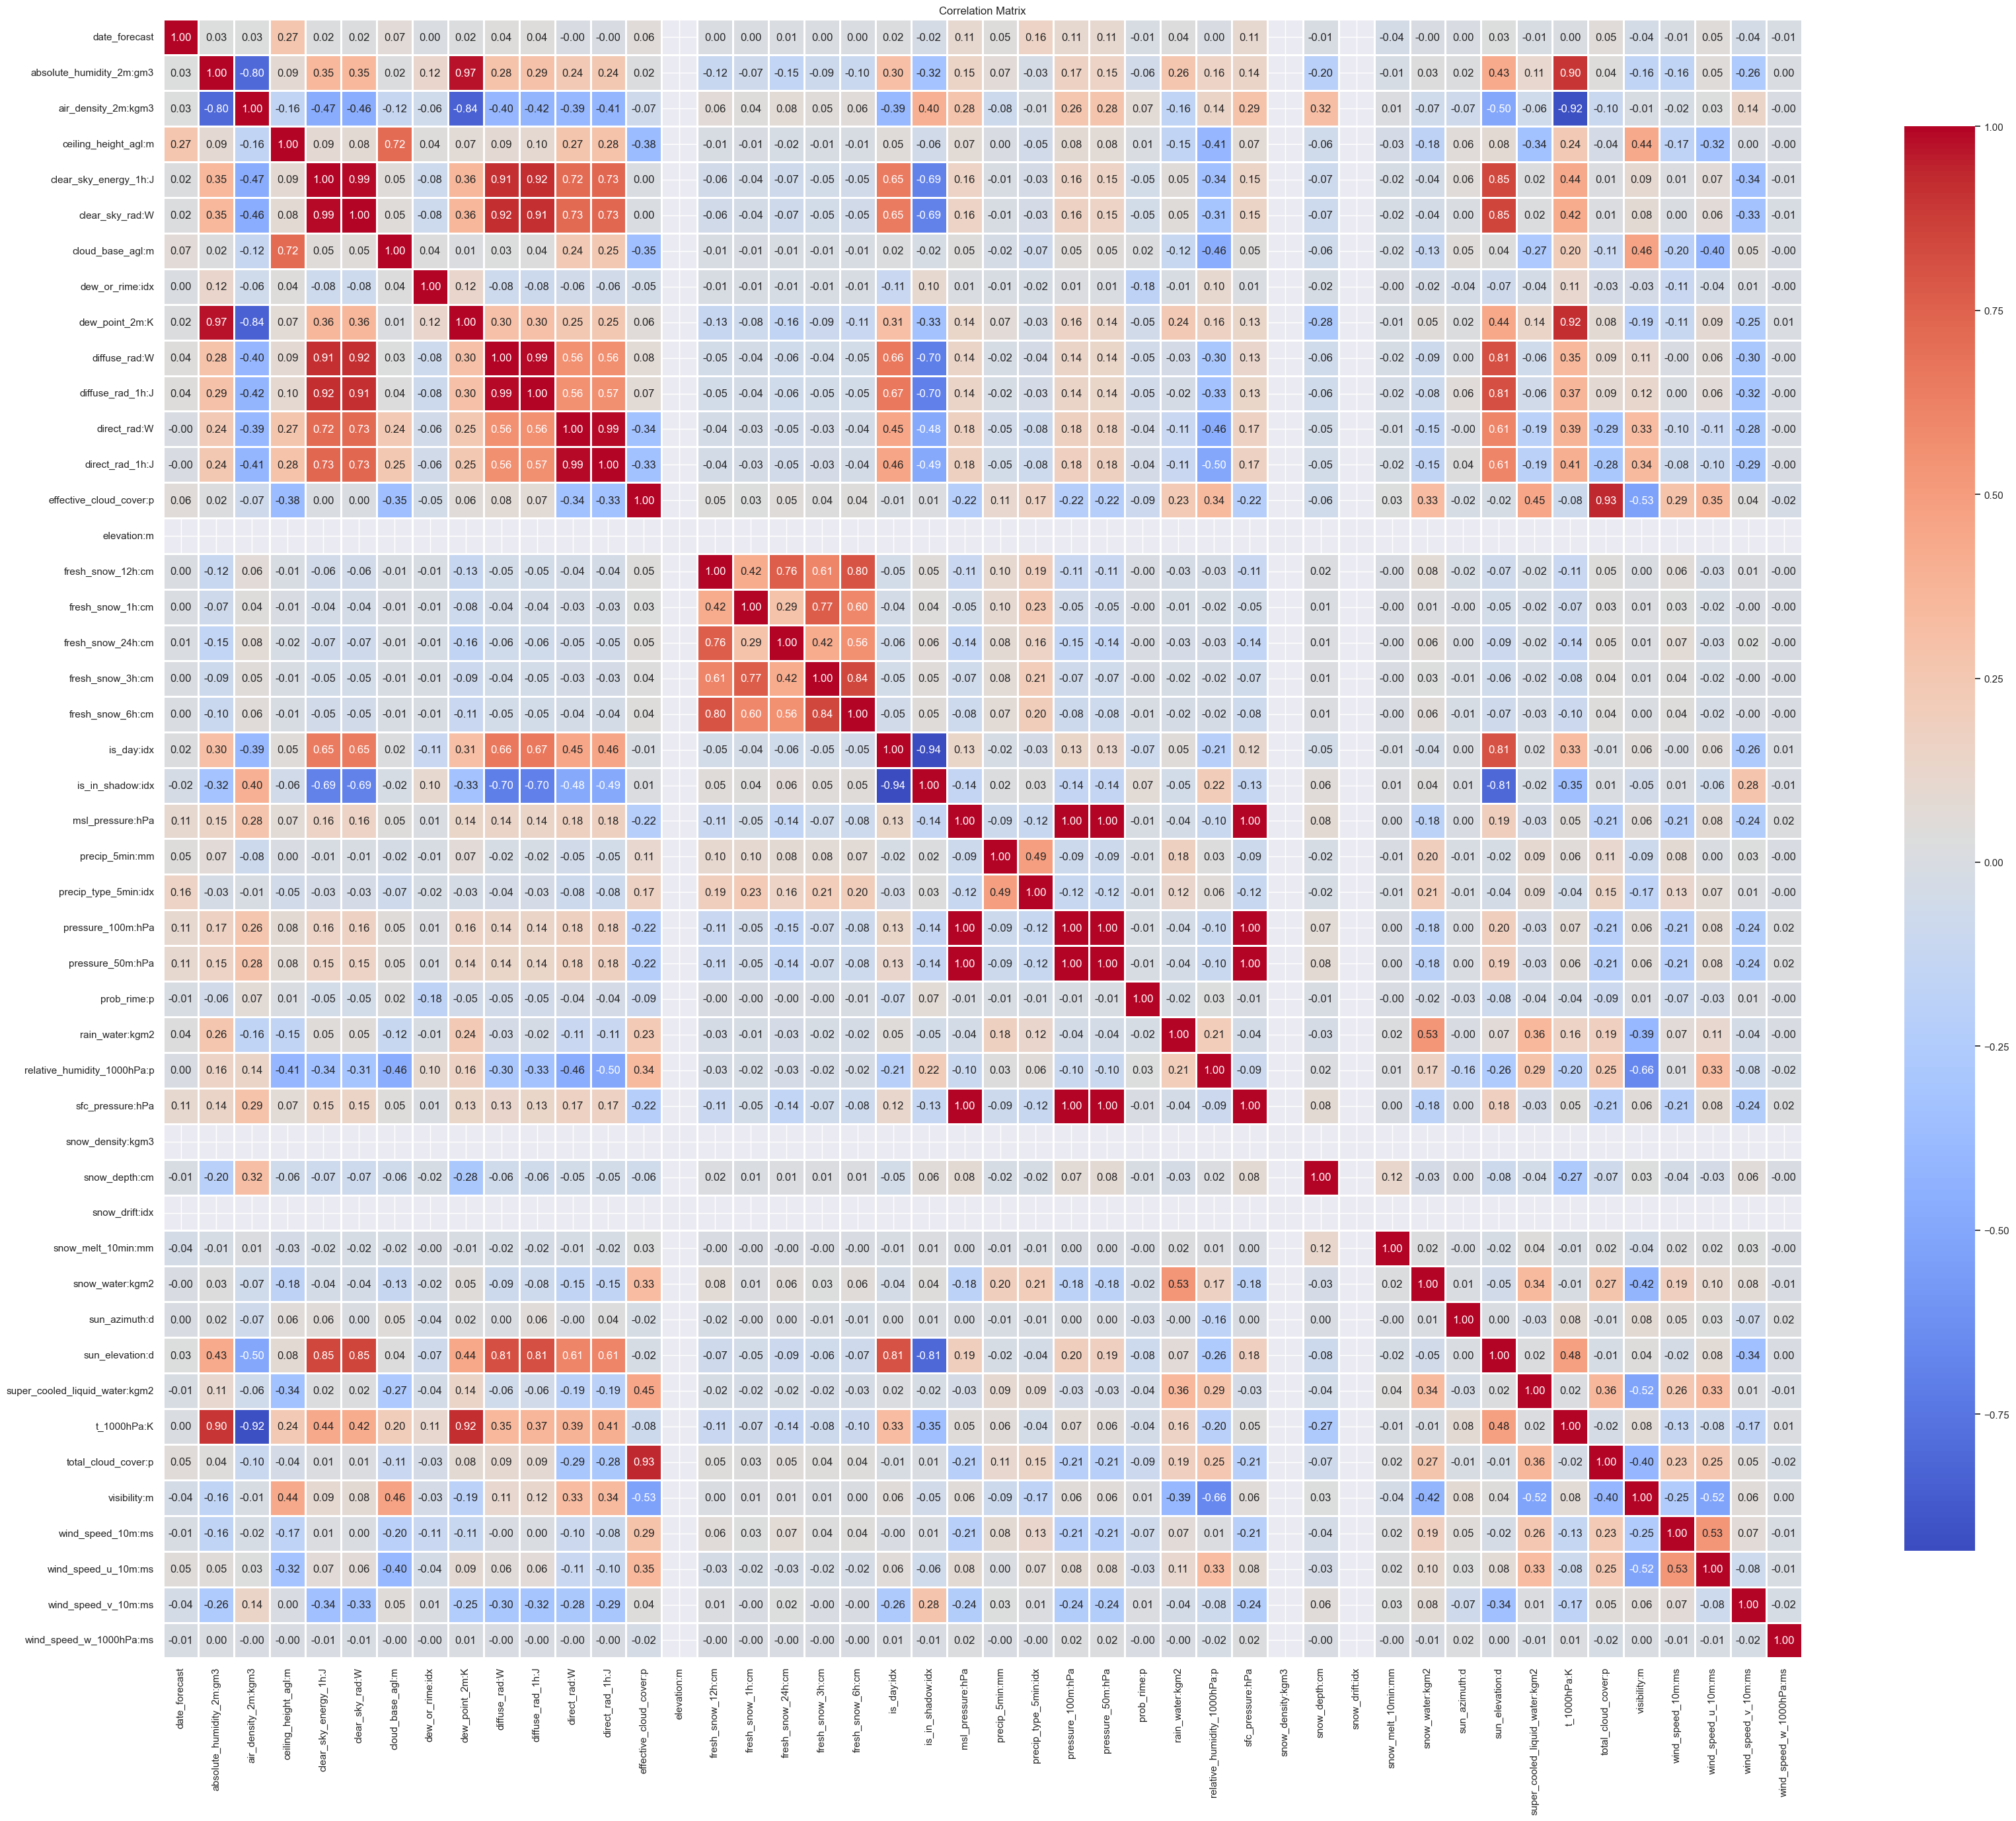

In [32]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


# The data to plot
df = X_train_observed   

# Exclude the first column (date forecast, it's the time axis)
columns_to_include = df.columns[:]

# Calculate the correlation matrix for selected columns
correlation_matrix = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

We will now focus on removing the highly correlated features. For that, we use the following function :

In [3]:
def find_low_correlation_columns(dataframe, threshold, verbose = True):
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)

In [4]:
features = find_low_correlation_columns(X_train_observed,threshold=0.9)
print(f"{len(features)} features remaining")


# We now compute another correlation matrix to make sure that we excluded the correct features
# Select the non correlated features
columns_to_include = list(features)

# Calculate the correlation matrix for selected columns
correlation_matrix_filtered = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix_filtered,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

NameError: name 'X_train_observed' is not defined

There are still `NaN` values in the data (both features and target data) that we need to replace.

In [5]:
# Imput missing values fill with last valid observation
def fill_nan(Dataframe, feature):
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].fillna(method='ffill')
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].fillna(method='bfill')
           
        #plt.plot(new_column)
        #plt.scatter(it_na,new_column[it_na],s=10, c='red')
    
        if (np.any(new_column.isna()) == False):
            print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values")
    #else : print("No NaN values in " + feature)

In [12]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    for feature in features:
        fill_nan(dataframe,feature)
    index+=1

** WORKING ON train_target**
** WORKING ON X_train_observed**
Missing data in ceiling_height_agl:m  size  22247  out of 118669
Filled with ffill method
Missing data in cloud_base_agl:m  size  8066  out of 118669
Filled with ffill method
** WORKING ON X_train_estimated**
Missing data in ceiling_height_agl:m  size  3919  out of 17576
Filled with ffill method
Missing data in cloud_base_agl:m  size  2094  out of 17576
Filled with ffill method


C:\Users\NOE\AppData\Local\Temp\ipykernel_17152\633608867.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')


** WORKING ON X_test_estimated**
Missing data in ceiling_height_agl:m  size  793  out of 2880
Filled with ffill method
Missing data in cloud_base_agl:m  size  298  out of 2880
Filled with ffill method


## Train a simple model on the extracted features
Now that we have eliminated some "useless" features, we can try to train a basic model on the observed data to see how it performs.

There are a few manipulations to do in order to select the correct training data. First, we have different time resolutions:

- `X_train_observed` and `X_train_estimated` have a 15 minute time resolution.
- `train_target` has a 1h time resolution



In [13]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
YData = train_target
XData = pd.concat([X_train_observed])[FEATURES[1]]

# Make sure that the dates are in the correct order
YData.sort_values(by="time", inplace=True)
XData.sort_values(by="date_forecast", inplace=True)

# Now, we have to interpolate YData_selected to match the time interval of XData_selected
# First, ensure "time" column in YData_selected is in datetime format
YData['time'] = pd.to_datetime(YData['time'])
YData.set_index('time', inplace=True)
# Resample with a 15 minute time interval
YData_resampled = YData.resample('15T').interpolate(method='nearest') #  use 'linear' for better interpolation
YData_resampled = YData_resampled.reset_index()



# Extract the start and end dates from YData
start_date_Y = YData_resampled["time"].min()
end_date_Y = YData_resampled["time"].max()

# Extract the start and end dates from XData
start_date_X = XData["date_forecast"].min()
end_date_X = XData["date_forecast"].max()

# Only select dates where we have data for X and Y
start_date = max(start_date_Y,start_date_X)
end_date = min(end_date_Y,end_date_X)

# Select XData within the specified date range
XData_selected = XData[(XData["date_forecast"] >= start_date) & (XData["date_forecast"] <= end_date)]
YData_selected = YData_resampled[(YData_resampled["time"] >= start_date) & (YData_resampled["time"] <= end_date)]

XData_selected = XData_selected.drop(columns='date_forecast')

X_train, X_test, Y_train, Y_test = train_test_split(XData_selected,YData_selected['pv_measurement'], test_size=0.2, random_state=RANDOM_SEED)


We can now train the light gbm model

In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [15]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 31,
    "learning_rate": 0.05,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse}")

LightGBMError: Do not support special JSON characters in feature name.

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,cloud_base_agl:m,dew_or_rime:idx,direct_rad:W,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,7.7,1.230,1744.900024,0.0,1744.900024,0.0,0.0,98.699997,0.0,0.0,0.0,0.0,0.0,0.0,1006.799988,0.0,0.0,0.0,0.0,73.099998,0.0,-0.0,0.1,342.834015,-3.202000,0.0,39640.101562,3.7,-3.6,-0.8,-0.0
1,7.7,1.229,1734.000000,0.0,1734.000000,0.0,0.0,99.000000,0.0,0.0,0.0,0.0,0.0,0.0,1006.500000,0.0,0.0,0.0,0.0,72.199997,0.0,-0.0,0.2,346.294006,-3.650000,0.0,40123.898438,3.6,-3.6,-0.6,-0.0
2,7.7,1.228,1723.500000,0.0,1723.500000,0.0,0.0,99.199997,0.0,0.0,0.0,0.0,0.0,0.0,1006.099976,0.0,0.0,0.0,0.0,71.199997,0.0,-0.0,0.2,349.768005,-3.998000,0.0,40628.300781,3.6,-3.6,-0.4,-0.0
3,7.7,1.226,1713.400024,0.0,1713.400024,0.0,0.0,99.400002,0.0,0.0,0.0,0.0,0.0,0.0,1005.799988,0.0,0.0,0.0,0.0,70.199997,0.0,-0.0,0.2,353.251007,-4.247000,0.0,41153.601562,3.5,-3.5,-0.2,-0.0
4,7.7,1.225,1703.599976,0.0,1703.599976,0.0,0.0,99.599998,0.0,0.0,0.0,0.0,0.0,0.0,1005.500000,0.0,0.0,0.0,0.0,69.199997,0.0,-0.0,0.2,356.742004,-4.393000,0.0,41699.898438,3.5,-3.5,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118664,5.0,1.292,1291.500000,0.0,149.500000,0.0,0.0,2.800000,0.0,0.0,0.0,0.0,0.0,0.0,1018.400024,0.0,0.0,0.0,0.0,82.699997,0.0,-0.0,0.0,16.612000,-36.306000,0.0,25791.000000,1.3,-0.4,1.2,-0.0
118665,5.0,1.292,1291.500000,0.0,149.500000,0.0,0.0,2.300000,0.0,0.0,0.0,0.0,0.0,0.0,1018.299988,0.0,0.0,0.0,0.0,83.099998,0.0,-0.0,0.0,21.132999,-35.762001,0.0,28560.599609,1.4,-0.6,1.2,-0.0
118666,5.0,1.292,1291.500000,0.0,149.500000,0.0,0.0,1.700000,0.0,0.0,0.0,0.0,0.0,0.0,1018.200012,0.0,0.0,0.0,0.0,83.400002,0.0,-0.0,0.0,25.594000,-35.095001,0.0,31317.800781,1.4,-0.8,1.2,-0.0
118667,5.0,1.292,1291.500000,0.0,149.500000,0.0,0.0,1.100000,0.0,0.0,0.0,0.0,0.0,0.0,1018.000000,0.0,0.0,0.0,0.0,83.800003,0.0,-0.0,0.0,29.988001,-34.311001,0.0,34062.601562,1.5,-1.0,1.1,-0.0
